In [1]:
import sys

sys.path.append('..')
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow_addons.metrics import F1Score
from tfvpc.model.resnet2D import Resnet2DBuilder
from tfvpc.preprocessing.two_dim import load_batch_dataset
from tfvpc.preprocessing.two_dim import count_tfrecord_examples
from tfvpc.utils.vis import show_confusion_matrix
from tensorflow_addons.losses import SigmoidFocalCrossEntropy



2021-08-31 15:56:39.519868: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
w_path = '../checkpoints/'
out_path = '../data/tfrecods/'
out_val_fname = 'val-2D-6cls-10'
out_test_fname = 'test-2D-6cls-10'
model_fname = '../checkpoints/resnet05-2D-6cls_checkpoint-10.h5'
out_val_ffname = os.path.join(out_path, out_val_fname + '.tfrecords')
out_test_ffname = os.path.join(out_path, out_test_fname + '.tfrecords')

# patch size: [n_rows, n_cols, n_planes]
n_rows = 32
n_cols = 32
n_classes = 6
vocab = [1,2,3,4,5,6]
n_channel = 1
epoch = 100
batch_size = 128
seed = 2020
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
val_dataset = load_batch_dataset(epoch,
                                 batch_size, 
                                 out_val_ffname,
                                 vocab,
                                 n_classes,
                                 aug =False, 
                                 train=False,
                                normalize = True)
print(f'nm of samples: {count_tfrecord_examples(out_val_ffname)}')
print(val_dataset.element_spec)

2021-08-31 15:56:47.663390: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-31 15:56:47.799120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 15:56:47.799719: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-08-31 15:56:47.799750: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-31 15:56:47.826737: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-31 15:56:47.826815: I tensorflow/stream_executor/platform/default/d

nm of samples: 30062
(TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))


# define model and load weights

In [4]:
resnet = Resnet2DBuilder.build_resnet_05((n_rows, n_cols, n_channel), n_classes)
resnet.load_weights(model_fname)
# resnet.summary()

In [5]:
metrics = [
    F1Score(n_classes, name='F1'),
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]
#compile model
resnet.compile(optimizer='adam',
               loss= 'categorical_crossentropy',
#                loss=SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.AUTO),
               metrics=metrics)
results = resnet.evaluate(val_dataset, batch_size=batch_size)

2021-08-31 15:57:07.827720: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-31 15:57:09.133890: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2021-08-31 15:57:10.900954: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


      1/Unknown - 5s 5s/step - loss: 0.0704 - F1: 0.1667 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

2021-08-31 15:57:12.025123: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


235/235 [==============================] - 6s 5ms/step - loss: 0.3489 - F1: 0.9054 - accuracy: 0.8985 - precision: 0.9073 - recall: 0.8890 - auc: 0.9881 - prc: 0.9546


In [6]:
validation_array = np.array(list(val_dataset.unbatch().take(-1).as_numpy_iterator()))
val_x = np.stack(validation_array[:,0])
val_y = np.stack(validation_array[:,1])
print(val_x.shape, val_y.shape)
# test_lbls_pred = np.argmax(resnet.predict(test_imgs), axis=1)
test_preds = resnet.predict(val_x)
test_lbls_pred = np.argmax(test_preds, axis=1)
test_lbls_gt =  np.argmax((val_y), axis=1)

/tmp/ipykernel_2791/2203574930.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  validation_array = np.array(list(val_dataset.unbatch().take(-1).as_numpy_iterator()))


(30062, 32, 32, 1) (30062, 6)


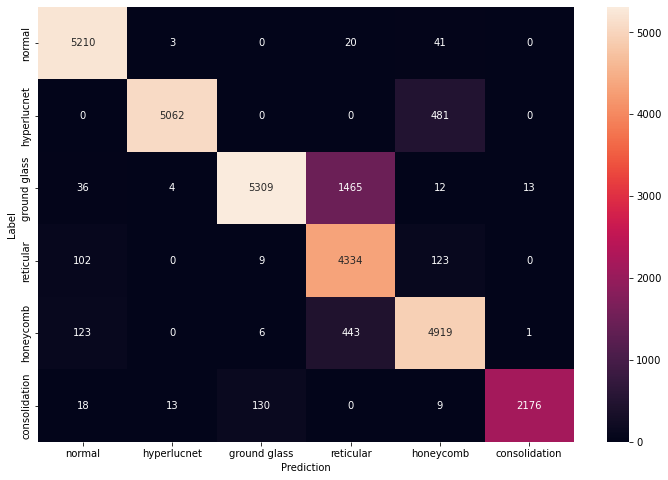

In [7]:
cf_matrix = tf.math.confusion_matrix(test_lbls_gt, test_lbls_pred)
label_names = ['normal','hyperlucnet','ground glass','reticular','honeycomb','consolidation']
show_confusion_matrix(cf_matrix, label_names)
n_per_class = cf_matrix.numpy().sum(axis=1)
tp_plus_fp_per_class = cf_matrix.numpy().sum(axis=0)
tp_per_class = tf.linalg.diag_part(cf_matrix).numpy()
fp_per_class = tp_plus_fp_per_class - tp_per_class
fn_per_class = n_per_class - tp_per_class
# tn_per_class = tp_per_class.sum() - tp_per_class
tn_per_class = cf_matrix.numpy().sum() - tp_per_class - fp_per_class - fn_per_class
# acc_per_class = tp_per_class / n_per_class
acc_per_class = (tp_per_class+tn_per_class) / (tp_per_class + fn_per_class + tn_per_class + fp_per_class)
precision_per_class = tp_per_class / tp_plus_fp_per_class
recall_per_class = tp_per_class / (tp_per_class + fn_per_class)
f1_per_class = (2*(precision_per_class * recall_per_class))/ (precision_per_class + recall_per_class)
specificity_per_class = tn_per_class / (tn_per_class + fp_per_class) 
ba_acc_per_class = (specificity_per_class + recall_per_class) / 2




In [8]:
cls_to_visualize = 3
# get indices for test patches
idx = np.array(list(range(len(test_lbls_gt))))
# Extact FNs

# mask to extract patches that belong to class-visualize
mask_cls = test_lbls_gt == cls_to_visualize
# extract indices of patches that belong to class-visualize
idx_cls = idx[mask_cls]
# mask to True positives
mask_tp = test_lbls_pred[idx_cls] == cls_to_visualize 
idx_cls_tp = idx_cls[mask_tp]
test_preds_tp = test_preds[idx_cls_tp, cls_to_visualize]
test_lbls_pred_tp = test_lbls_pred[idx_cls_tp]
test_patches_tp = val_x[idx_cls_tp, ...]
idx_cls_tp_ordered =  idx_cls_tp[test_preds_tp.argsort()][::-1]


# mask to extract patches that belong to class-visualize
mask_cls = test_lbls_gt == cls_to_visualize
# extract indices of patches that belong to class-visualize
idx_cls = idx[mask_cls]
# mask to False Negatives
mask_fn = test_lbls_pred[idx_cls] != cls_to_visualize 
idx_cls_fn = idx_cls[mask_fn]
test_preds_fn = test_preds[idx_cls_fn, cls_to_visualize]
test_lbls_pred_fn = test_lbls_pred[idx_cls_fn]
test_patches_fn = val_x[idx_cls_fn, ...]

# Extract TPs

# mask to extract patches predicted as class-visualize
mask_cls_pred = test_lbls_pred == cls_to_visualize
idx_cls_pred = idx[mask_cls_pred]
mask_fp = test_lbls_pred[idx_cls_pred] != test_lbls_gt[idx_cls_pred] 

idx_cls_fp = idx_cls_pred[mask_fp]
test_preds_fp = test_preds[idx_cls_fp, cls_to_visualize]
test_lbls_pred_fp = test_lbls_pred[idx_cls_fp]
test_lbls_gt_fp = test_lbls_gt[idx_cls_fp]
test_patches_fp = val_x[idx_cls_fp, ...]

idx_cls_fp_ordered =  idx_cls_fp[test_preds_fp.argsort()][::-1]

for i in idx_cls_fp_ordered.tolist():

    patch_i = val_x[i, ...]
    gt_lbl_i = test_lbls_gt[i]
    lbl_pred_i = test_lbls_pred[i]
    pred_i = test_preds[i, cls_to_visualize]
    
    print(gt_lbl_i, lbl_pred_i, pred_i)
    break

2 3 0.999998


17051 3 3 0.99993193


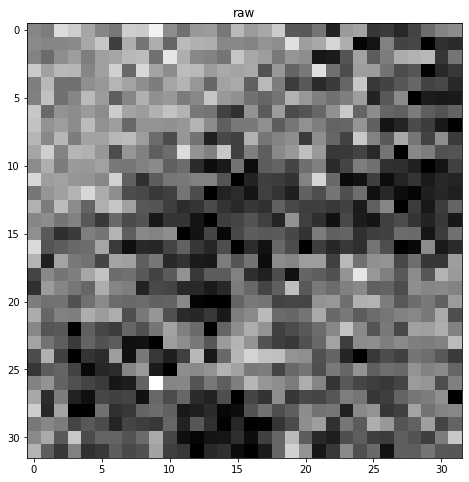

In [21]:
#TPs
from IPython.display import clear_output
import time
for i in idx_cls_tp.tolist():
    
    patch_i = val_x[i, ...]
    gt_lbl_i = test_lbls_gt[i]
    lbl_pred_i = test_lbls_pred[i]
    pred_i = test_preds[i, cls_to_visualize]
    
    print(i, gt_lbl_i, lbl_pred_i, pred_i)
    fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8, 8))
    axs.set_title('raw')
    axs.imshow(patch_i, cmap='gray')
    plt.show()
    clear_output(wait=True)
    time.sleep(1.99)
    break

19200

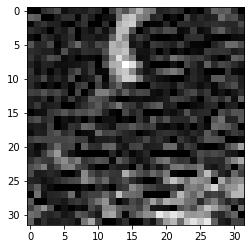

In [17]:
index = idx_cls_tp[test_preds_tp==test_preds_tp.min()]
plt.imshow(validation_array[index[0],0], cmap='gray')
index[0]

23025 2 3 0.999998


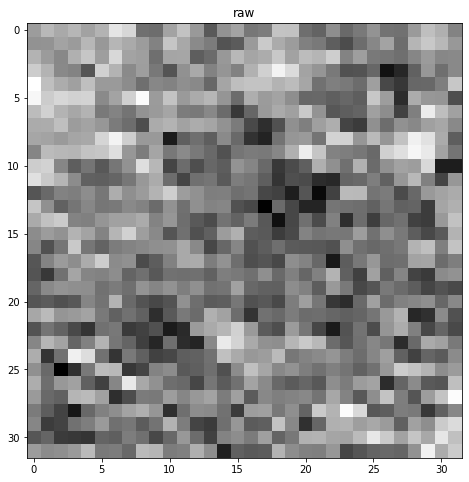

In [10]:
#FPs
from IPython.display import clear_output
import time
for i in idx_cls_fp_ordered.tolist():
    
    patch_i = val_x[i, ...]
    gt_lbl_i = test_lbls_gt[i]
    lbl_pred_i = test_lbls_pred[i]
    pred_i = test_preds[i, cls_to_visualize]
#     if gt_lbl_i==2:
    
    print(i, gt_lbl_i, lbl_pred_i, pred_i)
    fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8, 8))
    axs.set_title('raw')
    axs.imshow(patch_i, cmap='gray')
    plt.show()
    clear_output(wait=True)
    time.sleep(0.99)
    break
    

1600 4 3 0.24381468


array([5.3656187e-02, 6.7812996e-04, 1.6772539e-06, 5.5127084e-01,
       3.9439091e-01, 2.2762215e-06], dtype=float32)

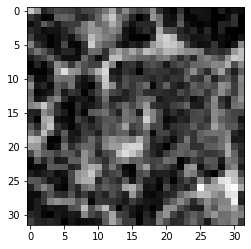

In [39]:
i = 1600
plt.imshow(validation_array[1600,0], cmap='gray')
# test_preds_fp
gt_lbl_i = test_lbls_gt[idx_cls_fp_ordered[1600]]
lbl_pred_i = test_lbls_pred[idx_cls_fp_ordered[1600]]
pred_i = test_preds[i, cls_to_visualize]
print(i, gt_lbl_i, lbl_pred_i, pred_i)
test_preds[i]
test_preds[idx_cls_fp_ordered[1600]]

## Test data

In [ ]:
test_dataset = load_batch_dataset(epoch,
                                  batch_size,
                                  out_test_ffname,
                                  vocab,
                                  n_classes,
                                  aug = False,
                                  train=False)
print(f'nm of test samples: {count_tfrecord_examples(out_test_ffname)}')
print(test_dataset.element_spec)

validation_array = np.array(list(test_dataset.unbatch().take(-1).as_numpy_iterator()))
test_x = np.stack(validation_array[:,0])
test_y = np.stack(validation_array[:,1])
print(test_x.shape, test_y.shape)

test_lbls_pred = np.argmax(resnet.predict(test_x), axis=1)
test_lbls_gt =  np.argmax((test_y), axis=1)

In [ ]:
results = resnet.evaluate(test_dataset, batch_size=128)

In [ ]:
cf_matrix = tf.math.confusion_matrix(test_lbls_gt, test_lbls_pred)
label_names = ['normal','hyperlucnet','ground glass','reticular','honeycomb','consolidation']
show_confusion_matrix(cf_matrix, label_names)

